In [1]:
# Import necessary libraries for PyTorch deep learning and visualization
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any  # Import type annotations

ImportError: dlopen(/opt/anaconda3/lib/python3.12/site-packages/torch/_C.cpython-312-darwin.so, 0x0002): Symbol not found: __ZN2at3cpu21is_amx_fp16_supportedEv
  Referenced from: <6BF8B9F7-0350-33D2-B461-559B51270DDA> /opt/anaconda3/lib/python3.12/site-packages/torch/lib/libtorch_python.dylib
  Expected in:     <616791F0-29C3-3F88-8A88-D072E7E40979> /opt/anaconda3/lib/libtorch_cpu.dylib

# Fashion MNIST Classification with PyTorch

This notebook demonstrates how to build, train, and evaluate a neural network model for classifying fashion items from the Fashion MNIST dataset using PyTorch. The Fashion MNIST dataset contains 70,000 grayscale images of 10 different clothing items, with 60,000 for training and 10,000 for testing.

In [2]:
# Download and prepare the Fashion MNIST dataset
# The dataset contains 28x28 grayscale images of clothing items

# Training data: 60,000 examples
training_data: datasets.FashionMNIST = datasets.FashionMNIST(
    root="data",           # Directory where the data will be stored
    train=True,           # Specifies that this is training data
    download=True,        # Download the dataset if it doesn't exist
    transform=ToTensor(), # Convert images to PyTorch tensors and normalize (0-1)
)

# Test data: 10,000 examples
test_data: datasets.FashionMNIST = datasets.FashionMNIST(
    root="data",           # Directory where the data will be stored
    train=False,          # Specifies that this is test data
    download=True,        # Download the dataset if it doesn't exist
    transform=ToTensor(), # Convert images to PyTorch tensors and normalize (0-1)
)

## Data Preparation

In this section, we'll download the Fashion MNIST dataset and prepare it for training. The dataset consists of 28x28 grayscale images of clothing items from 10 different categories.

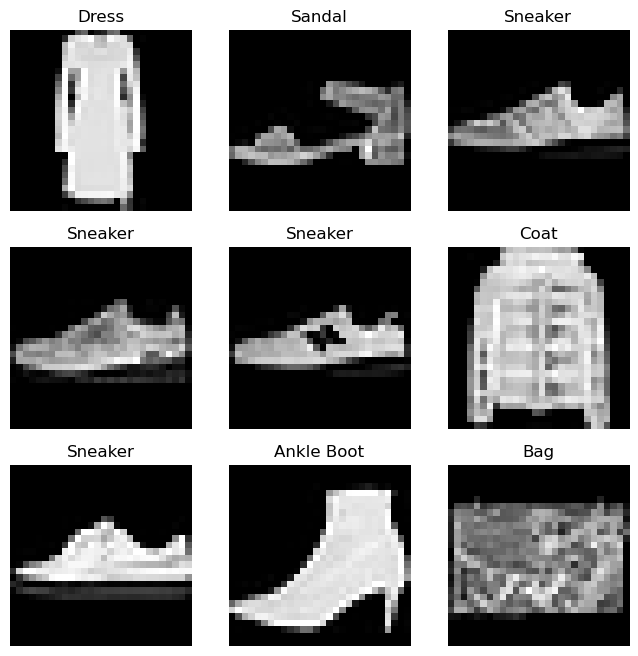

In [3]:
from typing import Dict

import matplotlib.pyplot as plt
import torch

# Create a mapping of class indices to their human-readable labels
labels_map: Dict[int, str] = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Visualize random samples from the training dataset to understand the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3  # Create a 3x3 grid of images

# Display 9 random samples with their labels
for i in range(1, cols * rows + 1):
    # Select a random image from the training dataset
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]  # Get image and its label

    # Add a subplot to our figure
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])  # Show the class name
    plt.axis("off")  # Hide axes
    plt.imshow(img.squeeze(), cmap="gray")  # Display the image in grayscale

plt.show()

## Creating DataLoaders

DataLoaders help efficiently load data in batches during training and testing. They handle shuffling, batching, and parallel loading of data.

In [4]:
from torch.utils.data import DataLoader

# Set the batch size for training and testing
# Batch size determines how many samples are processed together
batch_size: int = 64

# Create data loaders to efficiently load data during training and testing
# DataLoader provides features like batching, shuffling, and parallel data loading
train_dataloader: DataLoader = DataLoader(training_data, batch_size=batch_size)
test_dataloader: DataLoader = DataLoader(test_data, batch_size=batch_size)

# Inspect the shape of data and labels from one batch
for X, y in test_dataloader:
    # X shape is [batch_size, channels, height, width] - For MNIST: [64, 1, 28, 28]
    # y shape is [batch_size] - Labels for each image in the batch
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break  # Only inspect the first batch

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Model Definition

Now we'll define our neural network architecture for classifying the Fashion MNIST images. We'll use a simple feedforward neural network with fully connected layers.

In [5]:
import torch.nn.functional as F

# Set up the device for training (GPU if available, otherwise CPU)
device: str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define the VAE model
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        """
        Initialize the VAE with encoder, decoder, and classification components.
        
        Args:
            latent_dim: Dimension of the latent space (default: 128)
        """
        super().__init__()
        
        self.latent_dim = latent_dim
        
        # Encoder components
        self.flatten = nn.Flatten()  # Convert 28x28 images to 784-length vectors
        self.encoder_layers = nn.Sequential(
            nn.Linear(28 * 28, 512),  # First hidden layer
            nn.ReLU(),
            nn.Linear(512, 256),      # Second hidden layer
            nn.ReLU(),
        )
        
        # Latent space parameters (mu and log_var for the latent distributions)
        self.fc_mu = nn.Linear(256, latent_dim)         # Mean of the latent distribution
        self.fc_log_var = nn.Linear(256, latent_dim)    # Log variance of the latent distribution
        
        # Classification head (for class prediction from latent space)
        self.classifier = nn.Linear(latent_dim, 10)     # 10 classes for Fashion MNIST
        
        # Decoder components
        self.decoder_input = nn.Linear(latent_dim, 256)  # Input to decoder from latent space
        self.decoder_layers = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),                 # Output pixel values between 0 and 1
        )
        
    def encode(self, x):
        """
        Encode the input to latent space parameters (mu and log_var).
        
        Args:
            x: Input tensor of shape [batch_size, 1, 28, 28]
            
        Returns:
            mu: Mean of the latent distributions
            log_var: Log variance of the latent distributions
        """
        x = self.flatten(x)
        x = self.encoder_layers(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick: Sample from the latent distribution.
        
        This allows backpropagation through the sampling process.
        
        Args:
            mu: Mean of the latent distributions
            log_var: Log variance of the latent distributions
            
        Returns:
            Sampled latent vectors
        """
        std = torch.exp(0.5 * log_var)  # Standard deviation
        eps = torch.randn_like(std)     # Random noise from standard normal
        z = mu + eps * std              # Reparameterization trick
        
        return z
    
    def decode(self, z):
        """
        Decode latent vectors to reconstructed images.
        
        Args:
            z: Latent vectors from the reparameterize step
            
        Returns:
            Reconstructed images
        """
        x = self.decoder_input(z)
        x = self.decoder_layers(x)
        x = x.view(-1, 1, 28, 28)  # Reshape to image dimensions
        
        return x
        
    def forward(self, x):
        """
        Forward pass through the VAE.
        
        Args:
            x: Input tensor of shape [batch_size, 1, 28, 28]
            
        Returns:
            Tuple containing:
            - class_logits: Class predictions [batch_size, 10]
            - reconstructed: Reconstructed images [batch_size, 1, 28, 28]
            - mu: Mean of latent distributions
            - log_var: Log variance of latent distributions
        """
        # Encode input to latent distributions
        mu, log_var = self.encode(x)
        
        # Sample from the latent distributions
        z = self.reparameterize(mu, log_var)
        
        # Get class predictions from latent vectors
        class_logits = self.classifier(z)
        
        # Decode latent vectors to reconstructions
        reconstructed = self.decode(z)
        
        return class_logits, reconstructed, mu, log_var

Using cuda device


In [6]:
# Define a loss function for the VAE
def vae_loss_function(reconstructed, x, class_pred, y, mu, log_var, class_weight=1.0, kl_weight=0.1):
    """
    Compute the VAE loss function.
    
    Args:
        reconstructed: Reconstructed images
        x: Original images
        class_pred: Class predictions
        y: True labels
        mu: Mean of latent distributions
        log_var: Log variance of latent distributions
        class_weight: Weight for classification loss
        kl_weight: Weight for KL divergence loss
        
    Returns:
        Total loss, classification loss, reconstruction loss, KL divergence loss
    """
    # Classification loss (cross entropy)
    class_loss = F.cross_entropy(class_pred, y)
    
    # Reconstruction loss (binary cross entropy)
    # For images, BCE often works better than MSE for pixel values
    recon_loss = F.binary_cross_entropy(reconstructed, x, reduction='sum') / x.size(0)
    
    # KL divergence loss
    # Measures how much the encoded distributions differ from the prior (standard normal)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / x.size(0)
    
    # Total loss
    total_loss = recon_loss + class_weight * class_loss + kl_weight * kl_loss
    
    return total_loss, class_loss, recon_loss, kl_loss

# Create a VAE instance
vae_model = VariationalAutoencoder(latent_dim=128).to(device)
print(vae_model)

# Adam optimizer with learning rate 1e-3
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)

# Define VAE training function
def train_vae(dataloader, model, optimizer, class_weight=1.0, kl_weight=0.1):
    """
    Train the VAE for one epoch.
    
    Args:
        dataloader: DataLoader for training data
        model: VAE model
        optimizer: Optimization algorithm
        class_weight: Weight for classification loss
        kl_weight: Weight for KL divergence loss
    """
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        class_pred, reconstructed, mu, log_var = model(X)
        
        # Compute loss
        loss, class_loss, recon_loss, kl_loss = vae_loss_function(
            reconstructed, X, class_pred, y, mu, log_var, 
            class_weight=class_weight, kl_weight=kl_weight
        )
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Print progress
        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            print(f"loss: {loss.item():>7f} [class: {class_loss.item():>7f}, "
                  f"recon: {recon_loss.item():>7f}, kl: {kl_loss.item():>7f}] "
                  f"[{current:>5d}/{size:>5d}]")

# Define VAE evaluation function
def test_vae(dataloader, model, class_weight=1.0, kl_weight=0.1):
    """
    Evaluate the VAE on the test dataset.
    
    Args:
        dataloader: DataLoader for test data
        model: VAE model
        class_weight: Weight for classification loss
        kl_weight: Weight for KL divergence loss
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    
    test_loss = 0
    class_loss = 0
    recon_loss = 0
    kl_loss = 0
    correct = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            class_pred, reconstructed, mu, log_var = model(X)
            
            # Compute losses
            batch_loss, batch_class_loss, batch_recon_loss, batch_kl_loss = vae_loss_function(
                reconstructed, X, class_pred, y, mu, log_var,
                class_weight=class_weight, kl_weight=kl_weight
            )
            
            # Accumulate losses
            test_loss += batch_loss.item()
            class_loss += batch_class_loss.item()
            recon_loss += batch_recon_loss.item()
            kl_loss += batch_kl_loss.item()
            
            # Count correct predictions
            correct += (class_pred.argmax(1) == y).type(torch.float).sum().item()
    
    # Calculate average losses and accuracy
    test_loss /= num_batches
    class_loss /= num_batches
    recon_loss /= num_batches
    kl_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, "
          f"Avg loss: {test_loss:>8f}, "
          f"Class loss: {class_loss:>8f}, "
          f"Recon loss: {recon_loss:>8f}, "
          f"KL loss: {kl_loss:>8f} \n")

# Train the VAE for multiple epochs
epochs = 15
class_weight = 1.0  # Weight for classification loss
kl_weight = 0.1     # Weight for KL divergence loss (start small)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_vae(train_dataloader, vae_model, vae_optimizer, 
             class_weight=class_weight, kl_weight=kl_weight)
    test_vae(test_dataloader, vae_model, 
            class_weight=class_weight, kl_weight=kl_weight)
    
    # Optionally increase KL weight during training for better disentanglement
    # kl_weight = min(1.0, kl_weight + 0.05)
    
print("Done!")

# Save the trained VAE model
torch.save(vae_model.state_dict(), "vae_model.pth")
print("Saved VAE Model State to vae_model.pth")


VariationalAutoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=128, bias=True)
  (fc_log_var): Linear(in_features=256, out_features=128, bias=True)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
  (decoder_input): Linear(in_features=128, out_features=256, bias=True)
  (decoder_layers): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Epoch 1
-------------------------------
loss: 548.564514 [class: 2.455724, recon: 546.073608, kl: 0.351388] [   64/60000]
loss: 281.654480 [class: 1.535113, recon: 276.384003, kl: 37.353638] [ 6464/60000]
loss: 266.205750 [class: 0.989986, recon: 259.513550, kl: 57.02

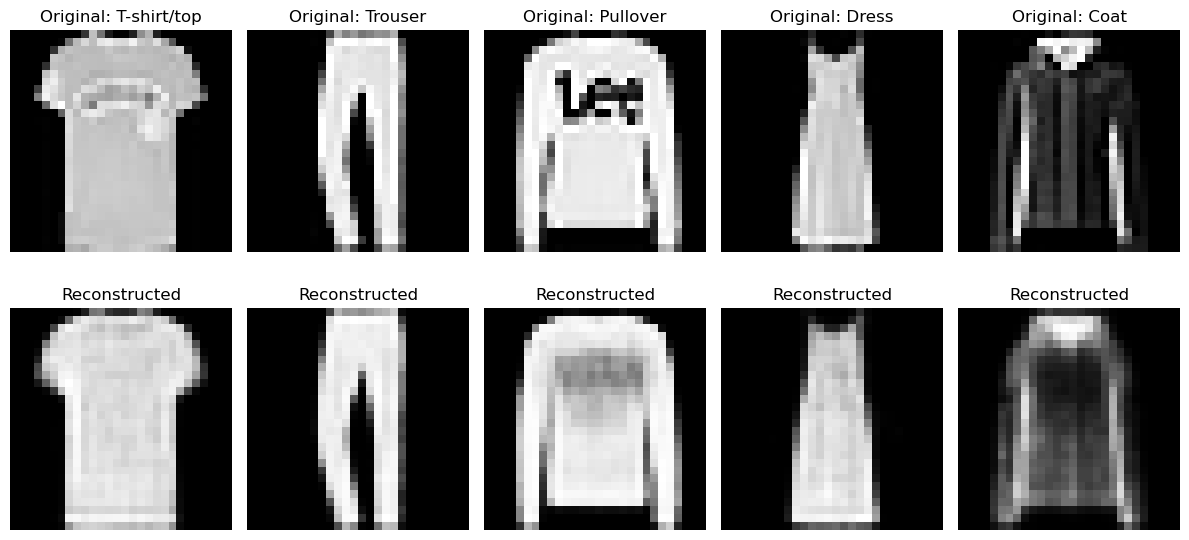

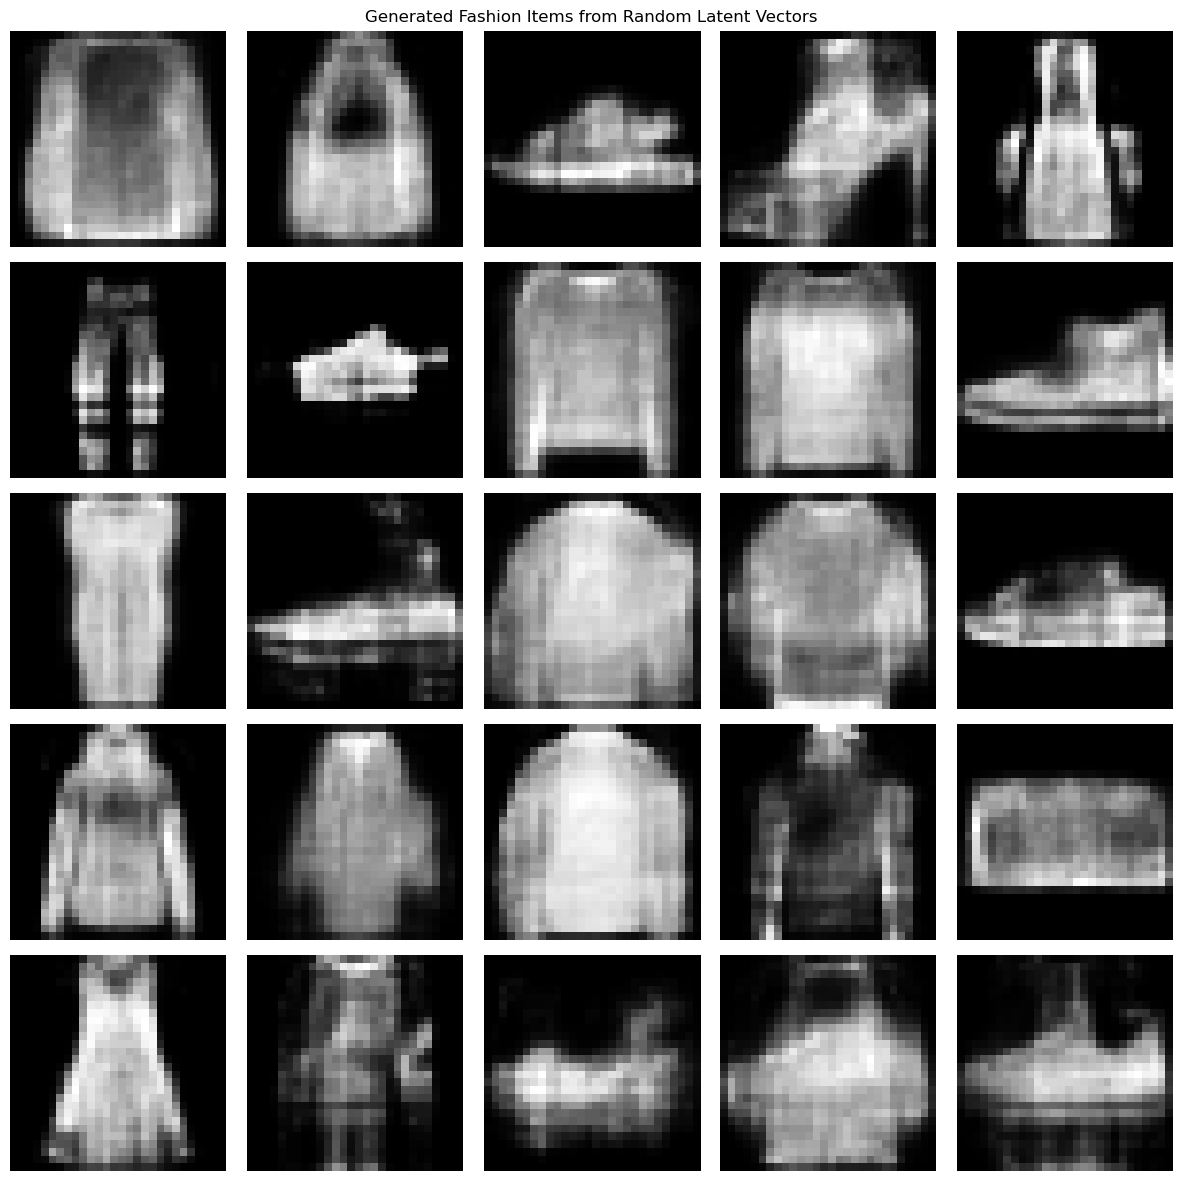

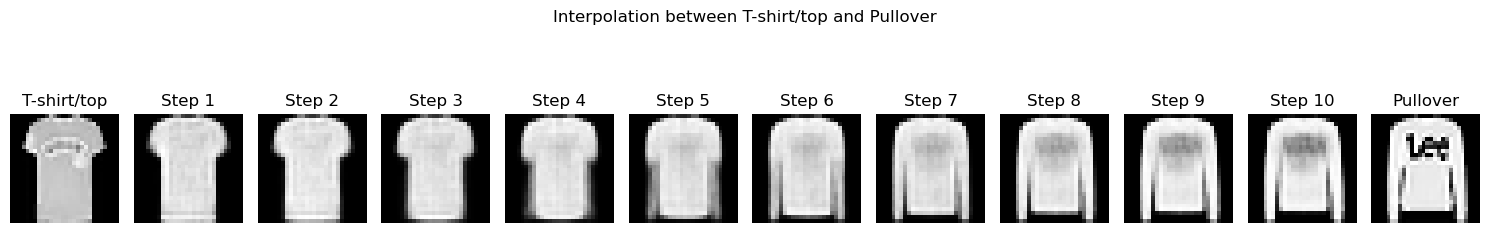

In [7]:
# Visualize VAE reconstructions and generate new samples
# Define the class names for the 10 categories in Fashion MNIST
classes: List[str] = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Function to find examples of each class in the test dataset
def find_examples_of_all_classes(dataset, classes_list):
    # Create a dictionary to store indices for each class
    class_indices = {i: [] for i in range(len(classes_list))}

    # Find examples of each class
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        # Store up to 2 examples of each class
        if len(class_indices[label]) < 2:
            class_indices[label].append(idx)

        # Check if we have enough examples of each class
        if all(len(indices) >= 2 for indices in class_indices.values()):
            break

    # Return first example of each class
    return [indices[0] for indices in class_indices.values()]


# Load the trained VAE model (if needed)
vae_model = VariationalAutoencoder(latent_dim=128).to(device)
vae_model.load_state_dict(torch.load("vae_model.pth", weights_only=True))
vae_model.eval()

# 1. Visualize Reconstructions from the Test Set
plt.figure(figsize=(12, 6))
with torch.no_grad():
    # Get some test examples
    example_indices = find_examples_of_all_classes(test_data, classes)[:5]  # Take 5 examples
    
    for i, idx in enumerate(example_indices):
        # Get the test example
        x, y = test_data[idx][0], test_data[idx][1]
        x = x.to(device)
        
        # Pass through VAE
        class_pred, reconstructed, mu, log_var = vae_model(x.unsqueeze(0))
        
        # Original image
        plt.subplot(2, 5, i+1)
        plt.title(f"Original: {classes[y]}")
        plt.imshow(x.cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
        
        # Reconstructed image
        plt.subplot(2, 5, i+6)
        plt.title(f"Reconstructed")
        plt.imshow(reconstructed[0].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')

plt.tight_layout()
plt.show()

# 2. Generate New Samples by Sampling from the Latent Space
plt.figure(figsize=(12, 12))

with torch.no_grad():
    # Sample random points from the latent space
    z = torch.randn(25, 128).to(device)  # 25 random points in 128-dim latent space
    
    # Decode these random points to generate new images
    generated = vae_model.decode(z)
    
    # Display the generated images
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(generated[i].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
        
    plt.suptitle("Generated Fashion Items from Random Latent Vectors")
    plt.tight_layout()
    plt.show()

# 3. Interpolate Between Two Latent Vectors to Show Smooth Transitions
plt.figure(figsize=(15, 3))

with torch.no_grad():
    # Get two different examples
    idx1, idx2 = example_indices[0], example_indices[2]  # Choose two different classes
    x1, y1 = test_data[idx1][0], test_data[idx1][1]
    x2, y2 = test_data[idx2][0], test_data[idx2][1]
    
    x1, x2 = x1.to(device), x2.to(device)
    
    # Encode both to the latent space
    mu1, _ = vae_model.encode(x1.unsqueeze(0))
    mu2, _ = vae_model.encode(x2.unsqueeze(0))
    
    # Create 8 interpolated points between the two latent vectors
    steps = 10
    interpolated = []
    
    for step in range(steps):
        # Linear interpolation between mu1 and mu2
        alpha = step / (steps - 1)
        z = mu1 * (1 - alpha) + mu2 * alpha
        
        # Decode the interpolated latent vector
        reconstructed = vae_model.decode(z)
        interpolated.append(reconstructed)
    
    # Show original images and interpolated images
    plt.subplot(1, steps+2, 1)
    plt.title(f"{classes[y1]}")
    plt.imshow(x1.cpu().squeeze().numpy(), cmap='gray')
    plt.axis('off')
    
    for i in range(steps):
        plt.subplot(1, steps+2, i+2)
        plt.title(f"Step {i+1}")
        plt.imshow(interpolated[i][0].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
        
    plt.subplot(1, steps+2, steps+2)
    plt.title(f"{classes[y2]}")
    plt.imshow(x2.cpu().squeeze().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.suptitle(f"Interpolation between {classes[y1]} and {classes[y2]}")
    plt.tight_layout()
    plt.show()

## Comparing VAE with Standard Autoencoder

The Variational Autoencoder (VAE) differs from the standard autoencoder in several important ways:

| Feature | Standard Autoencoder | Variational Autoencoder |
|---------|---------------------|-------------------------|
| Latent Space | Deterministic points | Probability distributions |
| Sampling | No sampling | Uses reparameterization trick |
| Loss Function | Reconstruction loss only | Reconstruction + KL divergence |
| Generation | Limited generative capability | Can generate diverse new samples |
| Latent Space Structure | Irregular/unpredictable | Regularized toward standard normal |
| Interpolation | May produce unrealistic results | Smoother, more meaningful transitions |

### Key Advantages of VAE

1. **Better generative capabilities**: Can generate novel, realistic images by sampling from the latent space
2. **Structured latent space**: The regularization creates a more organized latent space
3. **Meaningful interpolation**: Interpolating between points produces smoother transitions
4. **Probabilistic framework**: Handles uncertainty in a principled way

### Implementation Changes

To convert the standard autoencoder to a VAE, we made these key modifications:

1. Changed the encoder to output mean (μ) and log-variance (log σ²) of latent distributions
2. Added a reparameterization step for sampling from these distributions
3. Modified the loss function to include the KL divergence term
4. Used a more complex network architecture to handle the probabilistic nature

These changes allow the VAE to learn a more structured latent space and generate new, diverse fashion items that weren't in the original dataset.